In [1]:
import os

In [2]:
PATH =  os.getcwd()

In [3]:
%run -i code/utils.py

# 1. Initialization

In [4]:
# Prompts user for FDS and fds2ascii executable paths & email to send notifcation
#fds_bin = input('File path to FDS executable: ')
#fds2ascii = input('File path to fds2ascii utility in FDS: ')
fds_bin = '/home1/02410/lvalera/FDS/FDS6.7.5/bin/fds'          # Stampede2
fds2ascii = '/home1/02410/lvalera/FDS/FDS6.7.5/bin/fds2ascii'  # Stampede2

#fds_bin = '/home/leobardovalera/FDS/FDS6/bin/fds'             # Local
#fds2ascii = '/home/leobardovalera/FDS/FDS6/bin/fds2ascii'     # Local

## 1.1 Initial Region of Interest

In [ ]:
# Reads in elevation file to extract region information
name_of_file = 'Data/chimmey_tops_dem_1m_utm17n.csv'
Mst_original = read_elevation(name_of_file)
Image_name   = 'Image/Chimney_tops_aerial_Big.png'

In [ ]:
# Global Coordinates
North = 1000
South = 0
East  = 1000
West  = 0
# Coordinates of the Region's Border 
Min_x = 400       
Max_x = 600

Min_y = 0
Max_y = 200

Mst   = Mst_original.copy()
Mst['Elevation']   = Mst['Elevation']-Mst['Elevation'].min()
Mst = Mst[(Mst.x > Min_x-1) 
        & (Mst.x < Max_x+1) 
        & (Mst.y > Min_y-1) 
        & (Mst.y < Max_y+1)]

In [ ]:
# Defines the Resolution of the Meshes and the obstacles (in Meters)
R = 4                                   # Resolution of Cells
Mst = Mst[(Mst.x%R==0) & (Mst.y%R==0)]  # Filters data 
Ro = 4    # Resolution of Obstacles

Mst['Elevation'] = Mst['Elevation']-Mst['Elevation']%Ro

# Radius of the fire from the center
fire_radius   = 100

In [ ]:
# Defines range of elevation
Min_z = math.floor(Mst['Elevation'].min())
Min_z = Min_z-(Min_z%(2*R))
Max_z = math.ceil(Mst['Elevation'].max())
Max_z = Max_z + (2*R-Max_z%(2*R))
Medio_z =  (Min_z + Max_z)/2
Min_z   = Medio_z-fire_radius
Max_z   = Medio_z+fire_radius
#Min_z    = 276
#Max_z    = 576
Regiones = [[Min_x,Max_x,Min_y,Max_y,Min_z,Max_z]]

## 1.2 Input FDS File Parameters

In [ ]:
# Index for regions that we are simulating
num_region = 1

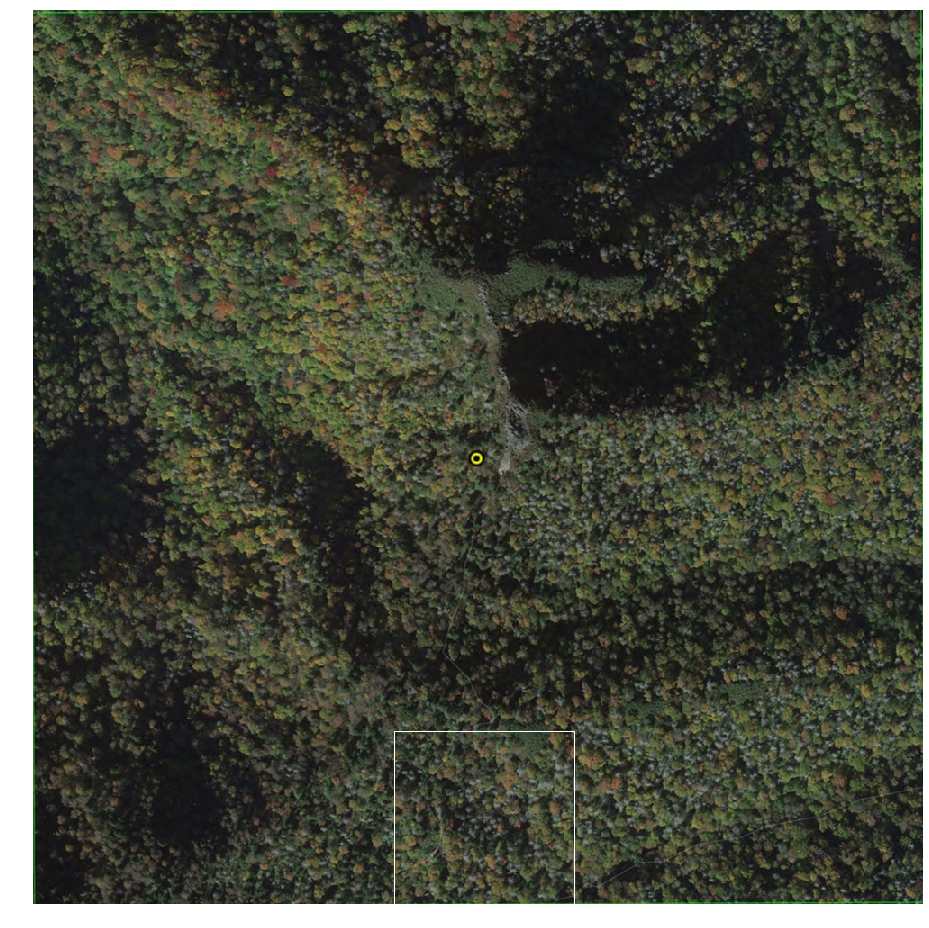

In [ ]:
# Set time interval
T_begin    = 0.0
DTT        = 60.0
T_end      = T_begin + DTT
DT         = 0.1

# Set Number of meshes in x, y, z directions
Nmx        = 2     
Nmy        = 2     
Nmz        = 2 

PC         = 1         # Predictor-Corrector Status Flag
Location   = [500,100] # Initial Location of the fire
Child      = f"Region{num_region}" # Start of Sequential Domain Decomposition
HRRPUA     = 1500      # Heat Release Rate (HRR)
rampa_time = 4       # Time that the fire ramp lasts

UVW_Timer  = 0
DT_UVW_Timer = 60
UVW_Timer  =  UVW_Timer + DT_UVW_Timer      # Time


# File name conventions
foldername = f'chimney'
filename   = f'{Child}.fds'

# Heat Release Rate (HRR) Minimum
hrr_threshold = 64

# Defining the dataframe with the HRR information
Hrr = Mst[(Mst['x'] < Location[0]+Ro+1) & (Mst['x'] > Location[0]-Ro-1) & (Mst['y'] < Location[1]+Ro+1) & (Mst['y'] > Location[1]-Ro-1)]
Hrr = Hrr[[Hrr.columns[0],Hrr.columns[1]]]
Hrr['hrr'] = HRRPUA
Hrr.to_csv(f'{PATH}/FDSFiles/{foldername}/Hrr_{Child}.csv', index=False)
# Function to write input FDS file with parameter specified above
write_fds_file(T_begin, T_end, DT, PC, Nmx, Nmy, Nmz, Hrr, Child)

## 1.3 Sets Folders

In [ ]:
FDS_FOLDER = f"FDSFiles/{foldername}" # Location of input FDS file

os.chdir(f'{PATH}/{FDS_FOLDER}')      # Changes directory to run the input FDS file location

## 1.4 Runs FDS

In [ ]:
# User decides to run as a job on a job scheduler or directly through mpiexec command
#job_type = input("Are you running with a job scheduler? \nIf so, is it LSF or Slurm?\nIf not, you do not have to specify. ")
job_type =''

In [ ]:
# Sets variables to use in job scripts/commands
num_nodes = 1             # Number of compute nodes to run job on
max_time = '3:00'         # Max time needed to run job (d-hh:mm:ss)
number_of_process = 8     # Number of processes(cores) needed to run the created meshes
omp_threads = 4           # Sets OpenMP Threads per process
jobName = f'FDS_{Child}'

In [ ]:
# Options: LSF, Slurm, or direct command (mpiexec)
if job_type=="LSF" or job_type=="Lsf" or job_type=='lsf':
    USER = os.getlogin()
    create_job_script_lsf(Child, num_nodes, max_time, omp_threads)    # Creates LSF job submission script
    os.system(f'bsub < job_{Child}.bsub') # Submits job script to the LSF job scheduler
    
    job_id = Get_job_id(['bjobs', '-u', USER])
    jobs = [job_id]
    wait_on_lsf()
    
elif job_type=="SLURM" or job_type=="Slurm" or job_type=="slurm":
    USER = os.getlogin()
    
#     partition = 'skx-normal' # Can be changed to another other partition used on TACC's Stampede2
    
    create_job_script_slurm(Child, num_nodes, max_time, omp_threads)  # Creates Slurm job submission script
    os.system(f'sbatch job_{Child}.sh')   # Submits job script to the Slurm job Scheduler
    
    job_id - Get_job_id(['squeue', '-u', USER])
    jobs = [job_id]
    wait_on_slurm()
    
else: 
    os.environ['OMP_NUM_THREADS'] = f'{omp_threads}'                  # Sets OpenMP Threads to 4
    os.system(f"mpiexec -n {number_of_process} {fds_bin} {filename}") # Runs FDS using 'mpiexec' command

# 2 Checkpoint Data Extraction

## 2.1 Parses plot3d files 

In [ ]:
Run_Region = True

UVW_Timer  =  UVW_Timer + DT_UVW_Timer      # Time


while(Run_Region):
    # Corrects .smv in order to work with fds2ascii
    remove_leading_space(f'{Child}.smv') 

    # Reads HRR data in plot3d files
    os.chdir(PATH)
    Number_of_meshes = Nmx*Nmy*Nmz
    reading_hrr(Child, Number_of_meshes)

    ## 2.2 Extracts & converts HRR data to CSV files

    # Reset current location back to starting location
    os.chdir(PATH)

    # Converts the CSV Files into Dataframes to be used to extract Heat Release Rate Values
    Hrr = pd.DataFrame()
    for i in range(1,Number_of_meshes+1):
        temp = pd.read_csv(f"{FDS_FOLDER}/{Child}_{i}.csv")
        temp = temp.drop(temp.index[0])
        temp = temp.reset_index(drop=True)
        Hrr  = Hrr.append(temp)
        Hrr = Hrr.reset_index(drop=True)
    Hrr = Hrr[[Hrr.columns[0],Hrr.columns[1],Hrr.columns[2],Hrr.columns[7]]]
    Hrr.columns = ['x','y','z','hrr']
    file1 = open(f'FDSFiles/chimney/{Child}_hrr.csv', 'r') 
    Lines = file1.readlines() 
    Ultima_linea = Lines[-1].split(",",3)
    hrr_value = float(Ultima_linea[1])
    if(float(Ultima_linea[1])==0.0):
        break
    rad_frac  = -float(Ultima_linea[2])/float(Ultima_linea[1]) 

    # Cleans the data and sets the data type
    Hrr["hrr"] = pd.to_numeric(Hrr["hrr"], downcast="float")
    Hrr["x"] = pd.to_numeric(Hrr["x"], downcast="float")
    Hrr["y"] = pd.to_numeric(Hrr["y"], downcast="float")
    Hrr["z"] = pd.to_numeric(Hrr["z"], downcast="float")
    Mst["x"] = pd.to_numeric(Mst["x"], downcast="float")
    Mst["y"] = pd.to_numeric(Mst["y"], downcast="float")
    Mst.shape
    # Filters HRR values greater than the specified threshold
    Hrr = Hrr[Hrr['hrr'] >= hrr_threshold]
    #Hrr = Hrr[Hrr['hrr'] != 0]
    minimo_x = Hrr['x'].min()
    maximo_x = Hrr['x'].max()
  
    minimo_y = Hrr['y'].min()
    maximo_y = Hrr['y'].max()

    # Defining the center of the location of the fire
    #indice_maximo = Hrr['hrr'].idxmax()
    #center_x =  math.floor(Hrr['x'].loc[indice_maximo])
    #center_y =  math.floor(Hrr["y"].loc[indice_maximo])
    if (math.isnan(minimo_x) or math.isnan(maximo_x) or math.isnan(minimo_y) or math.isnan(maximo_y)):
        break
    center_x = math.floor((minimo_x+maximo_x)/2)
    center_y = math.floor((minimo_y+maximo_y)/2)
    
    center_x = center_x - (center_x%Ro)
    center_y = center_y - (center_y%Ro)
    
    if ((center_x < West)  or (center_x > East) or (center_y < South) or (center_y > North)):
        break

    # Update Region Number to next one, if needed
    num_region = num_region + 1

    # Coordinates of the new region's border
    Min_x = max(center_x - fire_radius, West)
    Max_x = min(center_x + fire_radius, East)
    Min_y = max(center_y - fire_radius, South)
    Max_y = min(center_y + fire_radius, North) 
    Mst   = Mst_original.copy()
    Mst = Mst[(Mst.x > Min_x-Ro-1) & (Mst.x < Max_x+Ro+1) & (Mst.y > Min_y-Ro-1) & (Mst.y < Max_y+Ro+1)]
    Mst = Mst[(Mst.x%Ro==0) & (Mst.y%Ro==0)]
    Mst['Elevation'] = Mst['Elevation']-Mst['Elevation']%Ro
    # Range of elevation
    # Defines range of elevation
    Min_z = math.floor(Mst['Elevation'].min())
    Min_z = Min_z-(Min_z%(2*R))
    Max_z = math.ceil(Mst['Elevation'].max())
    Max_z = Max_z + (2*R-Max_z%(2*R))
    
    Medio_z =  (Min_z + Max_z)/2
    Min_z   = Medio_z-fire_radius
    Max_z   = Medio_z+fire_radius
    
    
    
    Regiones.append([Min_x,Max_x,Min_y,Max_y,Min_z,Max_z])
    if(Hrr['hrr'].sum()==0):
        break
    # Delete the cell if it is under the obstacles
    Hrr = delete_under(Hrr)
    
    # Determining the 'volumen' of the cells
    
    #Hrr['hrr'] = (hrr_value/(Rx*Ry*Rz*Hrr['hrr'].sum()))*Hrr['hrr']
    Hrr['hrr'] = (hrr_value/(Hrr['hrr'].sum()))*Hrr['hrr']
    
    if (Hrr.shape[0] < 1):
        break
    # Repeat Steps 1.2 - 3 (Loop)

    # Defines input variables for the next region (with respect to the previous FDS run)
    T_begin = T_end
    T_end   = T_begin+DTT
    Child   = f"Region{num_region}"
    foldername = f'chimney'
    filename   = f'{Child}.fds'
    Hrr.to_csv(f'{PATH}/FDSFiles/{foldername}/Hrr_{Child}.csv', index=False)
    # Recreates input FDS file for the next region of interest
    restart_fds_file(T_begin, T_end, DT, PC, Nmx, Nmy, Nmz, Hrr, Child)

    # Change current location to the input FDS file location
    os.chdir(f"{PATH}/{FDS_FOLDER}") 

    # Clear the list of jobids
    if 'jobs' in locals():
        jobs.clear()

    # Options: LSF, Slurm, or direct command (mpiexec)
    if job_type=="LSF" or job_type=="Lsf" or job_type=='lsf':
        create_job_script_lsf(Child, num_nodes, max_time, omp_threads)    # Creates LSF job submission script
        os.system(f'bsub < job_{Child}.bsub') # Submits job script to the LSF job scheduler

        job_id = Get_job_id(['bjobs', '-u', USER])
        #job_id = input("Enter Job ID just started: ") # Gets the job id & waits for it to finish to run the rest of the notebook
        jobs = [job_id]
        wait_on_lsf()
    elif job_type=="SLURM" or job_type=="Slurm" or job_type=="slurm":
        create_job_script_slurm(Child, num_nodes, max_time, omp_threads)  # Creates Slurm job submission script
        os.system(f'sbatch job_{Child}.sh')   # Submits job script to the Slurm job Scheduler

        job_id = input("Enter Job ID just started: ") # Gets the job id & waits for it to finish to run the rest of the notebook
        jobs = [job_id]
        wait_on_slurm()
    else: 
        os.environ['OMP_NUM_THREADS'] = f'{omp_threads}'                  # Sets OpenMP Threads to 4
        os.system(f"mpiexec -n {number_of_process} {fds_bin} {filename}") # Runs FDS using 'mpiexec' command


364 232
2440361.8
320 316
329954.2


In [ ]:
Regiones = pd.DataFrame(Regiones)
Regiones.columns=['Min_x','Max_x','Min_y','Max_y','Min_z','Max_z']
Regiones.to_csv(f'{PATH}/FDSFiles/{foldername}/Regiones.csv', index=False)

In [ ]:
if(Run_Region):
    if not path.exists(f"{PATH}/Regiones"):
        os.system(f"mkdir Regiones")
    os.system(f"cp {PATH}/FDSFiles/{foldername}/Region*_hrr.csv Regiones")
else:
    os.chdir(f"{PATH}")
    if not path.exists(f"{PATH}/Median"):
        os.system(f"mkdir Median")
    os.system(f"cp {PATH}/FDSFiles/{foldername}/Region*_hrr.csv {PATH}/Median/")

# Plotting the HRR 

In [ ]:
Region1hrr=pd.read_csv('Regiones/Region1_hrr.csv',skiprows=1)
Region2hrr=pd.read_csv('Regiones/Region2_hrr.csv',skiprows=1)
Region3hrr=pd.read_csv('Regiones/Region3_hrr.csv',skiprows=1)
RegionMhrr=pd.read_csv('Median/Region1_hrr.csv',skiprows=1)

In [ ]:
ax = plt.gca()
RegionMhrr.plot(kind='line',x='Time',y='HRR',color='#003333',ax=ax,label='Region1.2',linewidth=2)
Region1hrr.plot(kind='line',x='Time',y='HRR',color='#cc6600',ax=ax,label='Region1.2.1',linewidth=2)
Region2hrr.plot(kind='line',x='Time',y='HRR',color='#0000FF',ax=ax,label='Region1.2.2',linewidth=2)
Region3hrr.plot(kind='line',x='Time',y='HRR',color='#cc0066',ax=ax,label='Region1.2.3',linewidth=2)
plt.xlabel('Time ($t$)',fontsize = 'medium')
plt.ylabel('Heat Release Rate',fontsize = 'medium')

ax.grid()
plt.savefig(f'Figures/Simulated_Region1.2_3.png')
plt.show()

In [ ]:
ax = plt.gca()
Region1hrr.plot(kind='line',x='Time',y='HRR',color='#cc6600',ax=ax,label='Region1.2.1',linewidth=2)
Region2hrr.plot(kind='line',x='Time',y='HRR',color='#0000FF',ax=ax,label='Region1.2.2',linewidth=2)
Region3hrr.plot(kind='line',x='Time',y='HRR',color='#cc0066',ax=ax,label='Region1.2.3',linewidth=2)
plt.xlabel('Time')
plt.ylabel('Heat Release Rate')
plt.xlabel('Time ($t$)',fontsize = 'medium')
plt.ylabel('Heat Release Rate',fontsize = 'medium')
ax.grid()
plt.savefig(f'Figures/three_regions_cubed_3.png')
plt.show()